In [1]:
from img_pre import *
import numpy as np
from PIL import Image
from pynq import Overlay
from pynq import Xlnk
import cv2
import time
import matplotlib.pyplot as plt
import math
import struct
from add_wb import *
from numpy import unravel_index
import heapq 
import pandas as pd

MEANS = (104, 117, 123)
K=8
bitwidth=16

In [2]:
    ol=Overlay("ssd_dilation.bit")
    ol.download();
    dma=ol.axi_dma_0
    pool=ol.pool_0
    conv=ol.Conv_0
    xlnk=Xlnk()
    #feature
    image=xlnk.cma_array(shape=(1,300,300,K),cacheable=0,dtype=np.int16)
    vgg1_1=xlnk.cma_array(shape=(8,300,300,K),cacheable=0,dtype=np.int16)
    vgg1_2=xlnk.cma_array(shape=(8,300,300,K),cacheable=0,dtype=np.int16)
    vgg1_p=xlnk.cma_array(shape=(8,150,150,K),cacheable=0,dtype=np.int16)
    vgg2_1=xlnk.cma_array(shape=(16,150,150,K),cacheable=0,dtype=np.int16)
    vgg2_2=xlnk.cma_array(shape=(16,150,150,K),cacheable=0,dtype=np.int16)
    vgg2_p=xlnk.cma_array(shape=(16,75,75,K),cacheable=0,dtype=np.int16)
    vgg3_1=xlnk.cma_array(shape=(32,75,75,K),cacheable=0,dtype=np.int16)
    vgg3_2=xlnk.cma_array(shape=(32,75,75,K),cacheable=0,dtype=np.int16)
    vgg3_3=xlnk.cma_array(shape=(32,75,75,K),cacheable=0,dtype=np.int16)
    vgg3_cp=xlnk.cma_array(shape=(32,38,38,K),cacheable=0,dtype=np.int16)
    vgg4_1=xlnk.cma_array(shape=(32,38,38,K),cacheable=0,dtype=np.int16)
    vgg4_2=xlnk.cma_array(shape=(64,38,38,K),cacheable=0,dtype=np.int16)
    vgg4_3=xlnk.cma_array(shape=(64,38,38,K),cacheable=0,dtype=np.int16)
    l2_norm=xlnk.cma_array(shape=(64,38,38,K),cacheable=0,dtype=np.int16)
    #L1,C1
    vgg4_p=xlnk.cma_array(shape=(64,19,19,K),cacheable=0,dtype=np.int16)
    vgg5_1=xlnk.cma_array(shape=(64,19,19,K),cacheable=0,dtype=np.int16)
    vgg5_2=xlnk.cma_array(shape=(64,19,19,K),cacheable=0,dtype=np.int16)
    vgg5_3=xlnk.cma_array(shape=(64,19,19,K),cacheable=0,dtype=np.int16)
    vgg5_p=xlnk.cma_array(shape=(64,19,19,K),cacheable=0,dtype=np.int16)
    ex1_1=xlnk.cma_array(shape=(128,19,19,K),cacheable=0,dtype=np.int16)
    ex1_2=xlnk.cma_array(shape=(128,19,19,K),cacheable=0,dtype=np.int16)
    #L2,C2
    ex2_1=xlnk.cma_array(shape=(32,19,19,K),cacheable=0,dtype=np.int16)
    ex2_2=xlnk.cma_array(shape=(64,10,10,K),cacheable=0,dtype=np.int16)
    #L3,C3
    ex3_1=xlnk.cma_array(shape=(16,10,10,K),cacheable=0,dtype=np.int16)
    ex3_2=xlnk.cma_array(shape=(32,5,5,K),cacheable=0,dtype=np.int16)
    #L4,C4
    ex4_1=xlnk.cma_array(shape=(16,5,5,K),cacheable=0,dtype=np.int16)
    ex4_2=xlnk.cma_array(shape=(32,3,3,K),cacheable=0,dtype=np.int16)
    #L5,C5
    ex5_1=xlnk.cma_array(shape=(16,3,3,K),cacheable=0,dtype=np.int16)
    ex5_2=xlnk.cma_array(shape=(32,1,1,K),cacheable=0,dtype=np.int16)
    #L6,C6
    L1=xlnk.cma_array(shape=(2,38,38,K),cacheable=0,dtype=np.int16)
    C1=xlnk.cma_array(shape=(11,38,38,K),cacheable=0,dtype=np.int16)
    L2=xlnk.cma_array(shape=(3,19,19,K),cacheable=0,dtype=np.int16)
    C2=xlnk.cma_array(shape=(16,19,19,K),cacheable=0,dtype=np.int16)
    L3=xlnk.cma_array(shape=(3,10,10,K),cacheable=0,dtype=np.int16)
    C3=xlnk.cma_array(shape=(16,10,10,K),cacheable=0,dtype=np.int16)
    L4=xlnk.cma_array(shape=(3,5,5,K),cacheable=0,dtype=np.int16)
    C4=xlnk.cma_array(shape=(16,5,5,K),cacheable=0,dtype=np.int16)
    L5=xlnk.cma_array(shape=(2,3,3,K),cacheable=0,dtype=np.int16)
    C5=xlnk.cma_array(shape=(11,3,3,K),cacheable=0,dtype=np.int16)
    L6=xlnk.cma_array(shape=(2,1,1,K),cacheable=0,dtype=np.int16)
    C6=xlnk.cma_array(shape=(11,1,1,K),cacheable=0,dtype=np.int16)

    #weight
    
    #(cout,h,w,cin/k,K)
    vgg1_1w=xlnk.cma_array(shape=(64,3,3,1,K),cacheable=0,dtype=np.int16)
    vgg1_2w=xlnk.cma_array(shape=(64,3,3,8,K),cacheable=0,dtype=np.int16)
    vgg2_1w=xlnk.cma_array(shape=(128,3,3,8,K),cacheable=0,dtype=np.int16)
    vgg2_2w=xlnk.cma_array(shape=(128,3,3,16,K),cacheable=0,dtype=np.int16)
    vgg3_1w=xlnk.cma_array(shape=(256,3,3,16,K),cacheable=0,dtype=np.int16)
    vgg3_2w=xlnk.cma_array(shape=(256,3,3,32,K),cacheable=0,dtype=np.int16)
    vgg3_3w=xlnk.cma_array(shape=(256,3,3,32,K),cacheable=0,dtype=np.int16)
    vgg4_1w=xlnk.cma_array(shape=(512,3,3,32,K),cacheable=0,dtype=np.int16)
    vgg4_2w=xlnk.cma_array(shape=(512,3,3,64,K),cacheable=0,dtype=np.int16)
    vgg4_3w=xlnk.cma_array(shape=(512,3,3,64,K),cacheable=0,dtype=np.int16)
    vgg5_1w=xlnk.cma_array(shape=(512,3,3,64,K),cacheable=0,dtype=np.int16)
    vgg5_2w=xlnk.cma_array(shape=(512,3,3,64,K),cacheable=0,dtype=np.int16)
    vgg5_3w=xlnk.cma_array(shape=(512,3,3,64,K),cacheable=0,dtype=np.int16)
    ex1_1w=xlnk.cma_array(shape=(1024,3,3,64,K),cacheable=0,dtype=np.int16)
    ex1_2w=xlnk.cma_array(shape=(1024,1,1,128,K),cacheable=0,dtype=np.int16)
    ex2_1w=xlnk.cma_array(shape=(256,1,1,128,K),cacheable=0,dtype=np.int16)
    ex2_2w=xlnk.cma_array(shape=(512,3,3,32,K),cacheable=0,dtype=np.int16)
    ex3_1w=xlnk.cma_array(shape=(128,1,1,64,K),cacheable=0,dtype=np.int16)
    ex3_2w=xlnk.cma_array(shape=(256,3,3,16,K),cacheable=0,dtype=np.int16)
    ex4_1w=xlnk.cma_array(shape=(128,1,1,32,K),cacheable=0,dtype=np.int16)
    ex4_2w=xlnk.cma_array(shape=(256,3,3,16,K),cacheable=0,dtype=np.int16)
    ex5_1w=xlnk.cma_array(shape=(128,1,1,32,K),cacheable=0,dtype=np.int16)
    ex5_2w=xlnk.cma_array(shape=(256,3,3,16,K),cacheable=0,dtype=np.int16)
    l1=xlnk.cma_array(shape=(16,3,3,64,K),cacheable=0,dtype=np.int16)
    c1=xlnk.cma_array(shape=(84,3,3,64,K),cacheable=0,dtype=np.int16)
    l2=xlnk.cma_array(shape=(24,3,3,128,K),cacheable=0,dtype=np.int16)
    c2=xlnk.cma_array(shape=(126,3,3,128,K),cacheable=0,dtype=np.int16)
    l3=xlnk.cma_array(shape=(24,3,3,64,K),cacheable=0,dtype=np.int16)#16
    c3=xlnk.cma_array(shape=(126,3,3,64,K),cacheable=0,dtype=np.int16)
    l4=xlnk.cma_array(shape=(24,3,3,32,K),cacheable=0,dtype=np.int16)
    c4=xlnk.cma_array(shape=(126,3,3,32,K),cacheable=0,dtype=np.int16)
    l5=xlnk.cma_array(shape=(16,3,3,32,K),cacheable=0,dtype=np.int16)#126
    c5=xlnk.cma_array(shape=(84,3,3,32,K),cacheable=0,dtype=np.int16)
    l6=xlnk.cma_array(shape=(16,3,3,32,K),cacheable=0,dtype=np.int16)
    c6=xlnk.cma_array(shape=(84,3,3,32,K),cacheable=0,dtype=np.int16)
    L2Norm=xlnk.cma_array(shape=(512),cacheable=0,dtype=np.int16)

    ####bias
    vgg1_1b=xlnk.cma_array(shape=(64),cacheable=0,dtype=np.int16)
    vgg1_2b=xlnk.cma_array(shape=(64),cacheable=0,dtype=np.int16)
    vgg2_1b=xlnk.cma_array(shape=(128),cacheable=0,dtype=np.int16)
    vgg2_2b=xlnk.cma_array(shape=(128),cacheable=0,dtype=np.int16)
    vgg3_1b=xlnk.cma_array(shape=(256),cacheable=0,dtype=np.int16)
    vgg3_2b=xlnk.cma_array(shape=(256),cacheable=0,dtype=np.int16)
    vgg3_3b=xlnk.cma_array(shape=(256),cacheable=0,dtype=np.int16)
    vgg4_1b=xlnk.cma_array(shape=(512),cacheable=0,dtype=np.int16)
    vgg4_2b=xlnk.cma_array(shape=(512),cacheable=0,dtype=np.int16)
    vgg4_3b=xlnk.cma_array(shape=(512),cacheable=0,dtype=np.int16)
    vgg5_1b=xlnk.cma_array(shape=(512),cacheable=0,dtype=np.int16)
    vgg5_2b=xlnk.cma_array(shape=(512),cacheable=0,dtype=np.int16)
    vgg5_3b=xlnk.cma_array(shape=(512),cacheable=0,dtype=np.int16)
    ex1_1b=xlnk.cma_array(shape=(1024),cacheable=0,dtype=np.int16)
    ex1_2b=xlnk.cma_array(shape=(1024),cacheable=0,dtype=np.int16)
    ex2_1b=xlnk.cma_array(shape=(256),cacheable=0,dtype=np.int16)
    ex2_2b=xlnk.cma_array(shape=(512),cacheable=0,dtype=np.int16)
    ex3_1b=xlnk.cma_array(shape=(128),cacheable=0,dtype=np.int16)
    ex3_2b=xlnk.cma_array(shape=(256),cacheable=0,dtype=np.int16)
    ex4_1b=xlnk.cma_array(shape=(128),cacheable=0,dtype=np.int16)
    ex4_2b=xlnk.cma_array(shape=(256),cacheable=0,dtype=np.int16)
    ex5_1b=xlnk.cma_array(shape=(128),cacheable=0,dtype=np.int16)
    ex5_2b=xlnk.cma_array(shape=(256),cacheable=0,dtype=np.int16)
    l1b=xlnk.cma_array(shape=(16),cacheable=0,dtype=np.int16)
    c1b=xlnk.cma_array(shape=(84),cacheable=0,dtype=np.int16)
    l2b=xlnk.cma_array(shape=(24),cacheable=0,dtype=np.int16)
    c2b=xlnk.cma_array(shape=(126),cacheable=0,dtype=np.int16)
    l3b=xlnk.cma_array(shape=(24),cacheable=0,dtype=np.int16)
    c3b=xlnk.cma_array(shape=(126),cacheable=0,dtype=np.int16)
    l4b=xlnk.cma_array(shape=(24),cacheable=0,dtype=np.int16)
    c4b=xlnk.cma_array(shape=(126),cacheable=0,dtype=np.int16)
    l5b=xlnk.cma_array(shape=(16),cacheable=0,dtype=np.int16)
    c5b=xlnk.cma_array(shape=(84),cacheable=0,dtype=np.int16)
    l6b=xlnk.cma_array(shape=(16),cacheable=0,dtype=np.int16)
    c6b=xlnk.cma_array(shape=(84),cacheable=0,dtype=np.int16)

In [3]:
start=time.time()
#load weight
Load_Weight_From_File(vgg1_1w,'myrecord/vgg.0.weight.bin')
Load_Weight_From_File(vgg1_2w,'myrecord/vgg.2.weight.bin')
Load_Weight_From_File(vgg2_1w,'myrecord/vgg.5.weight.bin')
Load_Weight_From_File(vgg2_2w,'myrecord/vgg.7.weight.bin')
Load_Weight_From_File(vgg3_1w,'myrecord/vgg.10.weight.bin')
Load_Weight_From_File(vgg3_2w,'myrecord/vgg.12.weight.bin')
Load_Weight_From_File(vgg3_3w,'myrecord/vgg.14.weight.bin')
Load_Weight_From_File(vgg4_1w,'myrecord/vgg.17.weight.bin')
Load_Weight_From_File(vgg4_2w,'myrecord/vgg.19.weight.bin')
Load_Weight_From_File(vgg4_3w,'myrecord/vgg.21.weight.bin')
Load_Weight_From_File(vgg5_1w,'myrecord/vgg.24.weight.bin')
Load_Weight_From_File(vgg5_2w,'myrecord/vgg.26.weight.bin')
Load_Weight_From_File(vgg5_3w,'myrecord/vgg.28.weight.bin')
Load_Weight_From_File(ex1_1w,'myrecord/vgg.31.weight.bin')
Load_Weight_From_File(ex1_2w,'myrecord/vgg.33.weight.bin')
Load_Weight_From_File(ex2_1w,'myrecord/extras.0.weight.bin')
Load_Weight_From_File(ex2_2w,'myrecord/extras.1.weight.bin')
Load_Weight_From_File(ex3_1w,'myrecord/extras.2.weight.bin')
Load_Weight_From_File(ex3_2w,'myrecord/extras.3.weight.bin')
Load_Weight_From_File(ex4_1w,'myrecord/extras.4.weight.bin')
Load_Weight_From_File(ex4_2w,'myrecord/extras.5.weight.bin')
Load_Weight_From_File(ex5_1w,'myrecord/extras.6.weight.bin')
Load_Weight_From_File(ex5_2w,'myrecord/extras.7.weight.bin')
Load_Weight_From_File(l1,'myrecord/loc.0.weight.bin')
Load_Weight_From_File(c1,'myrecord/conf.0.weight.bin')
Load_Weight_From_File(l2,'myrecord/loc.1.weight.bin')
Load_Weight_From_File(c2,'myrecord/conf.1.weight.bin')
Load_Weight_From_File(l3,'myrecord/loc.2.weight.bin')
Load_Weight_From_File(c3,'myrecord/conf.2.weight.bin')
Load_Weight_From_File(l4,'myrecord/loc.3.weight.bin')
Load_Weight_From_File(c4,'myrecord/conf.3.weight.bin')
Load_Weight_From_File(l5,"myrecord/loc.4.weight.bin")
Load_Weight_From_File(c5,'myrecord/conf.4.weight.bin')
Load_Weight_From_File(l6,'myrecord/loc.5.weight.bin')
Load_Weight_From_File(c6,'myrecord/conf.5.weight.bin')
Load_Bias_From_File(L2Norm,'myrecord/L2Norm.weight.bin')

#Load_Bias_From_File
Load_Bias_From_File(vgg1_1b,'myrecord/vgg.0.bias.bin')
Load_Bias_From_File(vgg1_2b,'myrecord/vgg.2.bias.bin')
Load_Bias_From_File(vgg2_1b,'myrecord/vgg.5.bias.bin')
Load_Bias_From_File(vgg2_2b,'myrecord/vgg.7.bias.bin')
Load_Bias_From_File(vgg3_1b,'myrecord/vgg.10.bias.bin')
Load_Bias_From_File(vgg3_2b,'myrecord/vgg.12.bias.bin')
Load_Bias_From_File(vgg3_3b,'myrecord/vgg.14.bias.bin')
Load_Bias_From_File(vgg4_1b,'myrecord/vgg.17.bias.bin')
Load_Bias_From_File(vgg4_2b,'myrecord/vgg.19.bias.bin')
Load_Bias_From_File(vgg4_3b,'myrecord/vgg.21.bias.bin')
Load_Bias_From_File(vgg5_1b,'myrecord/vgg.24.bias.bin')
Load_Bias_From_File(vgg5_2b,'myrecord/vgg.26.bias.bin')
Load_Bias_From_File(vgg5_3b,'myrecord/vgg.28.bias.bin')
Load_Bias_From_File(ex1_1b,'myrecord/vgg.31.bias.bin')
Load_Bias_From_File(ex1_2b,'myrecord/vgg.33.bias.bin')
Load_Bias_From_File(ex2_1b,'myrecord/extras.0.bias.bin')
Load_Bias_From_File(ex2_2b,'myrecord/extras.1.bias.bin')
Load_Bias_From_File(ex3_1b,'myrecord/extras.2.bias.bin')
Load_Bias_From_File(ex3_2b,'myrecord/extras.3.bias.bin')
Load_Bias_From_File(ex4_1b,'myrecord/extras.4.bias.bin')
Load_Bias_From_File(ex4_2b,'myrecord/extras.5.bias.bin')
Load_Bias_From_File(ex5_1b,'myrecord/extras.6.bias.bin')
Load_Bias_From_File(ex5_2b,'myrecord/extras.7.bias.bin')
Load_Bias_From_File(l1b,'myrecord/loc.0.bias.bin')
Load_Bias_From_File(c1b,'myrecord/conf.0.bias.bin')
Load_Bias_From_File(l2b,'myrecord/loc.1.bias.bin')
Load_Bias_From_File(c2b,'myrecord/conf.1.bias.bin')
Load_Bias_From_File(l3b,'myrecord/loc.2.bias.bin')
Load_Bias_From_File(c3b,'myrecord/conf.2.bias.bin')
Load_Bias_From_File(l4b,'myrecord/loc.3.bias.bin')
Load_Bias_From_File(c4b,'myrecord/conf.3.bias.bin')
Load_Bias_From_File(l5b,"myrecord/loc.4.bias.bin")
Load_Bias_From_File(c5b,'myrecord/conf.4.bias.bin')
Load_Bias_From_File(l6b,'myrecord/loc.5.bias.bin')
Load_Bias_From_File(c6b,'myrecord/conf.5.bias.bin')
end=time.time()
print("load time=%s s"%(end-start))

load time=2577.613337278366 s


In [236]:

jpg_read=input("input img file")
image_read = Image.open(jpg_read)
image_shape = np.array(np.shape(image_read)[0:2])
#print(image_shape)
crop_img = np.array(letterbox_image(image_read, (300,300)))
#print(crop_img.shape)
#print(crop_img.dtype)

# plt.imshow(crop_img)
#plt.show()

#crop_img=np.transpose(crop_img-MEANS,(2,0,1))
crop_img=crop_img-MEANS
print(crop_img.shape)

for i in range(np.shape(crop_img)[0]):
    for j in range(np.shape(crop_img)[1]):
        for k in range(np.shape(crop_img)[2]):
            image[0][i][j][k]=crop_img[i][j][k];
print(image.shape)
        

input img fileimg/000228.jpg
(300, 300, 3)
(1, 300, 300, 8)


In [237]:
#Run_Conv(conv,chin,chout,kx,ky,sx,sy,mode,relu_en,feature_in,feature_in_precision,weight,weight_precision,bias,bias_precision,feature_out,feature_out_precision)
#mode(1 pad),relu_en(1 relu)
#Run_Pool(pool,dma,ch,kx,ky,feature_in,feature_out)
start=time.time()
Run_Conv(conv,3,64,3,3,1,1,1,1,0,image,0,vgg1_1w,15,vgg1_1b,14,vgg1_1,5)
print(vgg1_1.shape)
Run_Conv(conv,64,64,3,3,1,1,1,1,0,vgg1_1,5,vgg1_2w,15,vgg1_2b,15,vgg1_2,3)
print(vgg1_2.shape)
Run_Pool(pool,dma,64,2,2,vgg1_2,vgg1_p)
print(vgg1_p.shape)
#layer 2
Run_Conv(conv,64,128,3,3,1,1,1,1,0,vgg1_p,3,vgg2_1w,15,vgg2_1b,15,vgg2_1,2)
print(vgg2_1.shape)
Run_Conv(conv,128,128,3,3,1,1,1,1,0,vgg2_1,2,vgg2_2w,15,vgg2_2b,15,vgg2_2,2)
print(vgg2_2.shape)
Run_Pool(pool,dma,128,2,2,vgg2_2,vgg2_p)
print(vgg2_p.shape)
#layer 3
Run_Conv(conv,128,256,3,3,1,1,1,1,0,vgg2_p,2,vgg3_1w,15,vgg3_1b,15,vgg3_1,2)
print(vgg3_1.shape)
Run_Conv(conv,256,256,3,3,1,1,1,1,0,vgg3_1,2,vgg3_2w,15,vgg3_2b,15,vgg3_2,2)
print(vgg3_2.shape)
Run_Conv(conv,256,256,3,3,1,1,1,1,0,vgg3_2,2,vgg3_3w,15,vgg3_3b,15,vgg3_3,2)
print(vgg3_3.shape)
Run_Pool(pool,dma,256,2,2,vgg3_3,vgg3_cp)
print(vgg3_cp.shape)
#layer 4
Run_Conv(conv,256,512,3,3,1,1,1,1,0,vgg3_cp,2,vgg4_1w,15,vgg4_1b,15,vgg4_1,2)
print(vgg4_1.shape)
Run_Conv(conv,512,512,3,3,1,1,1,1,0,vgg4_1,2,vgg4_2w,15,vgg4_2b,15,vgg4_2,4)
print(vgg4_2.shape)
Run_Conv(conv,512,512,3,3,1,1,1,1,0,vgg4_2,4,vgg4_3w,15,vgg4_3b,15,vgg4_3,5)
print(vgg4_3.shape)
Run_Pool(pool,dma,512,2,2,vgg4_3,vgg4_p)
print(vgg4_p.shape)
#layer 5
Run_Conv(conv,512,512,3,3,1,1,1,1,0,vgg4_p,5,vgg5_1w,15,vgg5_1b,15,vgg5_1,6)
print(vgg5_1.shape)
Run_Conv(conv,512,512,3,3,1,1,1,1,0,vgg5_1,6,vgg5_2w,15,vgg5_2b,15,vgg5_2,7)
print(vgg5_2.shape)
Run_Conv(conv,512,512,3,3,1,1,1,1,0,vgg5_2,7,vgg5_3w,15,vgg5_3b,12,vgg5_3,7)
print(vgg5_3.shape)
Run_Pool_Soft_padding(512,3,3,vgg5_3,vgg5_p)
print(vgg5_p.shape)


#exter 1 dilation
Run_Conv(conv,512,1024,3,3,1,1,1,1,1,vgg5_p,7,ex1_1w,15,ex1_1b,15,ex1_1,9)
print('ex1_1',ex1_1.shape)
Run_Conv(conv,1024,1024,1,1,1,1,0,1,0,ex1_1,9,ex1_2w,15,ex1_2b,15,ex1_2,11)
print('ex1_2',ex1_2.shape)
#exter 2
Run_Conv(conv,1024,256,1,1,1,1,0,1,0,ex1_2,11,ex2_1w,15,ex2_1b,15,ex2_1,12)
print('ex2_1',ex2_1.shape)
Run_Conv(conv,256,512,3,3,2,2,1,1,0,ex2_1,12,ex2_2w,15,ex2_2b,15,ex2_2,11)
print('ex2_2',ex2_2.shape)
#exter 3
Run_Conv(conv,512,128,1,1,1,1,0,1,0,ex2_2,11,ex3_1w,15,ex3_1b,15,ex3_1,11)
print('ex3_1',ex3_1.shape)
Run_Conv(conv,128,256,3,3,2,2,1,1,0,ex3_1,11,ex3_2w,15,ex3_2b,15,ex3_2,10)
print('ex3_2',ex3_2.shape)
#exter 4
Run_Conv(conv,256,128,1,1,1,1,0,1,0,ex3_2,10,ex4_1w,15,ex4_1b,15,ex4_1,10)
print('ex4_1',ex4_1.shape)
Run_Conv(conv,128,256,3,3,1,1,0,1,0,ex4_1,10,ex4_2w,15,ex4_2b,15,ex4_2,10)
print('ex4_2',ex4_2.shape)
#exter 5
Run_Conv(conv,256,128,1,1,1,1,0,1,0,ex4_2,10,ex5_1w,15,ex5_1b,15,ex5_1,10)
print('ex5_1',ex5_1.shape)
Run_Conv(conv,128,256,3,3,1,1,0,1,0,ex5_1,10,ex5_2w,15,ex5_2b,15,ex5_2,9)
print('ex5_2',ex5_2.shape)
end=time.time()
print("Hardware run time=%s s"%(end-start))


(8, 300, 300, 8)
(8, 300, 300, 8)
(8, 150, 150, 8)
(16, 150, 150, 8)
(16, 150, 150, 8)
(16, 75, 75, 8)
(32, 75, 75, 8)
(32, 75, 75, 8)
(32, 75, 75, 8)
(32, 38, 38, 8)
(32, 38, 38, 8)
(64, 38, 38, 8)
(64, 38, 38, 8)
(64, 19, 19, 8)
(64, 19, 19, 8)
(64, 19, 19, 8)
(64, 19, 19, 8)
(64, 19, 19, 8)
ex1_1 (128, 19, 19, 8)
ex1_2 (128, 19, 19, 8)
ex2_1 (32, 19, 19, 8)
ex2_2 (64, 10, 10, 8)
ex3_1 (16, 10, 10, 8)
ex3_2 (32, 5, 5, 8)
ex4_1 (16, 5, 5, 8)
ex4_2 (32, 3, 3, 8)
ex5_1 (16, 3, 3, 8)
ex5_2 (32, 1, 1, 8)
Hardware run time=754.8998255729675 s


In [238]:
start=time.time()
#L
# Run_Conv(conv,1024,24,3,3,1,1,1,0,0,ex1_2,11,l2,15,l2b,15,L2,12)
# Run_Conv(conv,512,24,3,3,1,1,1,0,0,ex2_2,11,l3,15,l3b,15,L3,12)
Run_Conv(conv,256,24,3,3,1,1,1,0,0,ex3_2,10,l4,15,l4b,15,L4,12)
Run_Conv(conv,256,16,3,3,1,1,1,0,0,ex4_2,10,l5,15,l5b,15,L5,12)
# Run_Conv(conv,256,16,3,3,1,1,1,0,0,ex5_2,9,l6,15,l6b,15,L6,12)
#C
Run_Conv(conv,1024,126,3,3,1,1,1,0,0,ex1_2,11,c2,15,c2b,15,C2,10)
print(C2.shape)
Run_Conv(conv,512,126,3,3,1,1,1,0,0,ex2_2,11,c3,15,c3b,15,C3,10)
print(C3.shape)
Run_Conv(conv,256,126,3,3,1,1,1,0,0,ex3_2,10,c4,15,c4b,15,C4,10)
print(C4.shape)
Run_Conv(conv,256,84,3,3,1,1,1,0,0,ex4_2,10,c5,15,c5b,15,C5,10)
print(C5.shape)
Run_Conv(conv,256,84,3,3,1,1,1,0,0,ex5_2,9,c6,15,c6b,15,C6,10)
print(C6.shape)
end=time.time()
print("Hardware run time=%s s"%(end-start))

(16, 19, 19, 8)
(16, 10, 10, 8)
(16, 5, 5, 8)
(11, 3, 3, 8)
(11, 1, 1, 8)
Hardware run time=9.415188312530518 s


In [239]:
start=time.time()
class_name=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

# for i in range(C2.shape[0]):
#     for j in range(C2.shape[1]):
#         for k in range(C2.shape[2]):
#             for l in range(C2.shape[3]):
#                 if((i*8+l)%21==0):
#                     C2[i][j][k][l]=0
# for i in range(C3.shape[0]):
#     for j in range(C3.shape[1]):
#         for k in range(C3.shape[2]):
#             for l in range(C3.shape[3]):
#                 if((i*8+l)%21==0):
#                     C3[i][j][k][l]=0
for i in range(C4.shape[0]):
    for j in range(C4.shape[1]):
        for k in range(C4.shape[2]):
            for l in range(C4.shape[3]):
                if((i*8+l)%21==0):
                    C4[i][j][k][l]=0                    
for i in range(C5.shape[0]):
    for j in range(C5.shape[1]):
        for k in range(C5.shape[2]):
            for l in range(C5.shape[3]):
                if((i*8+l)%21==0):
                    C5[i][j][k][l]=0                    
# for i in range(C6.shape[0]):
#     for j in range(C6.shape[1]):
#         for k in range(C6.shape[2]):
#             for l in range(C6.shape[3]):
#                 if((i*8+l)%21==0):
#                     C6[i][j][k][l]=0  

class_num=[]
loc_num=[]
confloc_num_solo=[]
max_N=15

    
# idx2 = np.argsort(C2.ravel())[:-max_N-1:-1] 
# sort_idx2=np.column_stack(np.unravel_index(idx2, C2.shape))
# for i in range(max_N):
#     box_class2=(sort_idx2[i][0]*8+sort_idx2[i][3])%21-1
#     class_num.append(box_class2)
    
# idx3 = np.argsort(C3.ravel())[:-max_N-1:-1] 
# sort_idx3=np.column_stack(np.unravel_index(idx3, C3.shape))
# for i in range(max_N):
#     box_class3=(sort_idx3[i][0]*8+sort_idx3[i][3])%21-1
#     class_num.append(box_class3)
    
idx4 = np.argsort(C4.ravel())[:-max_N-1:-1] 
sort_idx4=np.column_stack(np.unravel_index(idx4, C4.shape))
for i in range(max_N):
    box_class4=(sort_idx4[i][0]*8+sort_idx4[i][3])%21-1
    class_num.append(box_class4)
    loc_num.append((sort_idx4[i][0],sort_idx4[i][1],sort_idx4[i][2],sort_idx4[i][3],4))
    
idx5 = np.argsort(C5.ravel())[:-max_N-1:-1] 
sort_idx5=np.column_stack(np.unravel_index(idx5, C5.shape))
for i in range(max_N):
    box_class5=(sort_idx5[i][0]*8+sort_idx5[i][3])%21-1
    class_num.append(box_class5)
    loc_num.append((sort_idx5[i][0],sort_idx5[i][1],sort_idx5[i][2],sort_idx5[i][3],5))
    
# idx6 = np.argsort(C5.ravel())[:-max_N-1:-1] 
# sort_idx6=np.column_stack(np.unravel_index(idx6, C5.shape))
# for i in range(max_N):
#     box_class6=(sort_idx6[i][0]*8+sort_idx6[i][3])%21-1
#     class_num.append(box_class6)
#plt.imshow(image_read)
#print(class_num)
class_num2=[]
for i,j in enumerate(class_num):
    if not j in class_num2:
        class_num2.append(j)
        confloc_num_solo.append(np.array(loc_num[i])) 
end=time.time()
print("Hardware run time=%s s"%(end-start))

Hardware run time=0.04846954345703125 s


In [240]:
print(confloc_num_solo)
int_idx=[]
drt_x=[]
drt_y=[]
drt_h=[]
drt_w=[]
l4_wh=[[0.54,0.54],[0.62,0.62],[0.76,0.38],[0.38,0.76],[0.93,0.31],[0.31,0.93]]
l5_wh=[[0.71,0.71],[0.79,0.79],[1,0.5],[0.5,1]]
for i in range(np.shape(confloc_num_solo)[0]):
    int_idx.append((confloc_num_solo[i][0]*8+confloc_num_solo[i][3])//21)
    drt_x.append(L4[int_idx[i]//2][confloc_num_solo[i][1]][confloc_num_solo[i][2]][(int_idx[i]%2)*4]>>12)
    drt_y.append(L4[int_idx[i]//2][confloc_num_solo[i][1]][confloc_num_solo[i][2]][((int_idx[i]%2)*4)+1]>>12)
    drt_w.append(L4[int_idx[i]//2][confloc_num_solo[i][1]][confloc_num_solo[i][2]][((int_idx[i]%2)*4)+2]>>12)
    drt_h.append(L4[int_idx[i]//2][confloc_num_solo[i][1]][confloc_num_solo[i][2]][((int_idx[i]%2)*4)+3]>>12)


[array([0, 2, 1, 1, 4])]


In [241]:
pre_box=[]
decode_box=[]
for i in range(np.shape(confloc_num_solo)[0]):
    if(confloc_num_solo[i][4]==4):
        pre_box.append([(confloc_num_solo[i][1]+0.5)/4.7,(confloc_num_solo[i][2]+0.5)/4.7]+l4_wh[int_idx[i]])
    if(confloc_num_solo[i][4]==5):
        pre_box.append([(confloc_num_solo[i][1]+0.5)/3,(confloc_num_solo[i][2]+0.5)/3]+l5_wh[int_idx[i]])
    pre_box[i][0]=pre_box[i][0]+drt_x[i]*0.1*pre_box[i][2]
    pre_box[i][1]=pre_box[i][1]+drt_y[i]*0.1*pre_box[i][3]
    pre_box[i][2]=pre_box[i][2]*np.exp(drt_h[i]*0.2)
    pre_box[i][3]=pre_box[i][3]*np.exp(drt_w[i]*0.2)
    
    x_1=pre_box[i][0]-(pre_box[i][2])/2
    y_1=pre_box[i][1]-(pre_box[i][3])/2
    x_2=x_1+pre_box[i][2]
    y_2=y_1+pre_box[i][3]
    decode_box.append([x_1,y_1,x_2,y_2])
print(x_2,y_2,x_1,y_1)

# pre_box = np.array(pre_box)
left1, top1, right1, bottom1 = np.expand_dims(np.array(decode_box)[:,0],-1),np.expand_dims(np.array(decode_box)[:,1],-1),np.expand_dims(np.array(decode_box)[:,2],-1),np.expand_dims(np.array(decode_box)[:,3],-1)

#correct_boxes=ssd_correct_boxes(pre_box[1],pre_box[0],pre_box[3],pre_box[2],np.array([300,300]),np.array([image_read.size[0],image_read.size[1]]))

0.801914893617 0.58914893617 0.261914893617 0.0491489361702


In [242]:
new_shape = image_shape*np.min(np.array([300,300])/np.array([image_read.size[0],image_read.size[1]]))

offset = (np.array([300,300])-new_shape)/2./np.array([300,300])
scale = np.array([300,300])/new_shape

# box_yx = ((pre_box[1]+pre_box[3])/2,(pre_box[0]+pre_box[2])/2)
# box_hw = (pre_box[3]-pre_box[1],pre_box[2]-pre_box[0])
box_yx = np.concatenate(((top1+bottom1)/2,(left1+right1)/2),axis=-1)
box_hw = np.concatenate((bottom1-top1,right1-left1),axis=-1)

box_yx = (box_yx - offset) * scale
box_hw *= scale

box_mins = box_yx - (box_hw / 2.)
box_maxes = box_yx + (box_hw / 2.)
boxes =  np.concatenate([
        box_mins[:, 0:1],
        box_mins[:, 1:2],
        box_maxes[:, 0:1],
        box_maxes[:, 1:2]],axis=-1)
print(np.shape(boxes))
boxes *= np.concatenate([image_shape, image_shape],axis=-1)


(1, 4)


   *********************************************
   >>>>>>>>>>>>>>In this picture<<<<<<<<<<<<<
   ———————————————————————
   *          aeroplane       
   ———————————————————————
   *********************************************


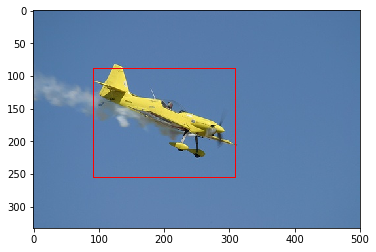

In [243]:
from PIL import Image,ImageFont, ImageDraw
for i in range(np.shape(confloc_num_solo)[0]):
    thickness = (np.shape(image_read)[0] + np.shape(image_read)[1]) // 300
    top, left, bottom, right = boxes[i]
    top = top - 5
    left = left - 5
    bottom = bottom + 5
    right = right + 5

    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(np.shape(image_read)[0], np.floor(bottom + 0.5).astype('int32'))
    right = min(np.shape(image_read)[1], np.floor(right + 0.5).astype('int32'))

    draw = ImageDraw.Draw(image_read)
    for i in range(thickness):
        draw.rectangle([left+i,top+i,right-i,bottom-i],outline='red')
    del draw
print("   *********************************************")
print("   >>>>>>>>>>>>>>In this picture<<<<<<<<<<<<<")
print("   ———————————————————————")
for i in class_num2:
    print("   *         ",class_name[i],"      ")
print("   ———————————————————————")    
print("   *********************************************")   
plt.imshow(image_read)